Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.99      0.71       887
           1       0.98      0.47      0.64      1313

    accuracy                           0.68      2200
   macro avg       0.77      0.73      0.68      2200
weighted avg       0.81      0.68      0.67      2200

F1 Score: 0.6382322713257965
ROC AUC Score: 0.7405852154029902
Confusion Matrix:
 [[875  12]
 [692 621]]


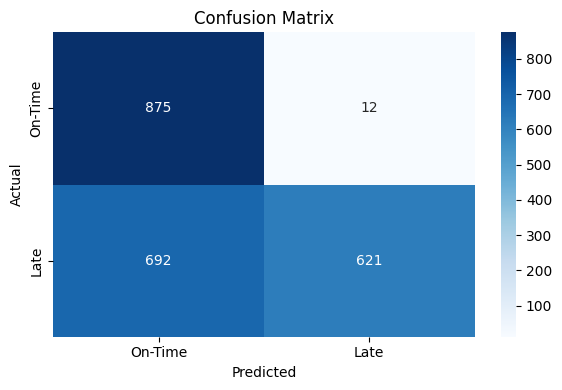

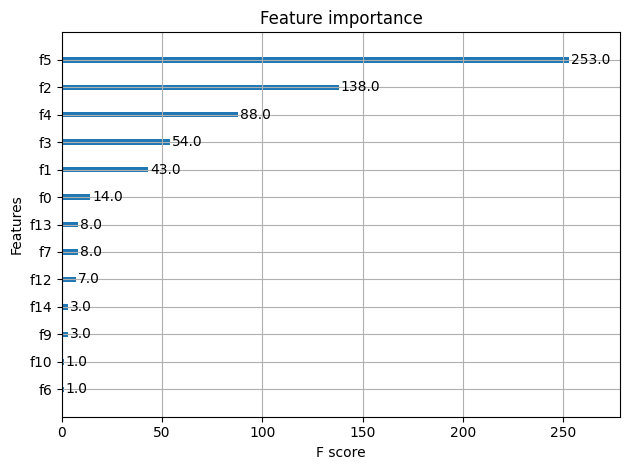

In [39]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("/kaggle/input/on-time-delivery/Train new.csv")
df.drop("ID", axis=1, inplace=True)
df['Late'] = df['Reached.on.Time_Y.N']
X = df.drop(['Reached.on.Time_Y.N', 'Late'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Late']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train fast and accurate XGBoost
xgb = XGBClassifier(n_estimators=80, max_depth=4, learning_rate=0.03,
                    scale_pos_weight=0.675, use_label_encoder=False,
                    eval_metric="logloss", random_state=42)

xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
y_prob = xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["On-Time", "Late"], yticklabels=["On-Time", "Late"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature importance
plot_importance(xgb, max_num_features=15)
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/kaggle/input/on-time-delivery/Train new.csv")
df.drop("ID", axis=1, inplace=True)
df['Late'] = df['Reached.on.Time_Y.N']
X = df.drop(['Reached.on.Time_Y.N', 'Late'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Late']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
xgb = XGBClassifier(n_estimators=80, max_depth=4, learning_rate=0.03, scale_pos_weight=0.675,
                    use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train_scaled, y_train)

# === Create 200 synthetic samples
synthetic = df.sample(200, random_state=42).copy()
np.random.seed(42)
synthetic['Cost_of_the_Product'] = np.random.randint(100, 400, size=len(synthetic))
synthetic['Prior_purchases'] = np.random.randint(0, 10, size=len(synthetic))
synthetic['Customer_rating'] = np.round(np.random.uniform(1.0, 5.0, size=len(synthetic)), 1)
synthetic['Weight_in_gms'] = np.random.randint(200, 8000, size=len(synthetic))
synthetic['Discount_offered'] = np.random.randint(0, 50, size=len(synthetic))
synthetic['Warehouse_block'] = np.random.choice(df['Warehouse_block'].unique(), size=len(synthetic))
synthetic['Mode_of_Shipment'] = np.random.choice(df['Mode_of_Shipment'].unique(), size=len(synthetic))
synthetic['Product_importance'] = np.random.choice(df['Product_importance'].unique(), size=len(synthetic))
synthetic['Gender'] = np.random.choice(df['Gender'].unique(), size=len(synthetic))
synthetic['Order_Date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 30, size=len(synthetic)), unit='D')
synthetic['DayOfWeek'] = synthetic['Order_Date'].dt.dayofweek
synthetic['IsWeekend'] = (synthetic['DayOfWeek'] >= 5).astype(int)

# Encode
synthetic = synthetic.drop(columns=['Reached.on.Time_Y.N', 'Late'], errors='ignore')
synthetic_encoded = pd.get_dummies(synthetic, drop_first=True)
for col in X.columns:
    if col not in synthetic_encoded.columns:
        synthetic_encoded[col] = 0
synthetic_encoded = synthetic_encoded[X.columns]
synthetic_scaled = scaler.transform(synthetic_encoded)
synthetic['Predicted_Probability_Late'] = xgb.predict_proba(synthetic_scaled)[:, 1]
synthetic['Predicted_Late'] = xgb.predict(synthetic_scaled)

# === Create 50 more synthetic samples
synthetic_50 = df.sample(50, random_state=101).copy()
np.random.seed(101)
synthetic_50['Cost_of_the_Product'] = np.random.randint(100, 400, size=len(synthetic_50))
synthetic_50['Prior_purchases'] = np.random.randint(0, 10, size=len(synthetic_50))
synthetic_50['Customer_rating'] = np.round(np.random.uniform(1.0, 5.0, size=len(synthetic_50)), 1)
synthetic_50['Weight_in_gms'] = np.random.randint(200, 8000, size=len(synthetic_50))
synthetic_50['Discount_offered'] = np.random.randint(0, 50, size=len(synthetic_50))
synthetic_50['Warehouse_block'] = np.random.choice(df['Warehouse_block'].unique(), size=len(synthetic_50))
synthetic_50['Mode_of_Shipment'] = np.random.choice(df['Mode_of_Shipment'].unique(), size=len(synthetic_50))
synthetic_50['Product_importance'] = np.random.choice(df['Product_importance'].unique(), size=len(synthetic_50))
synthetic_50['Gender'] = np.random.choice(df['Gender'].unique(), size=len(synthetic_50))
synthetic_50['Order_Date'] = pd.to_datetime('2023-02-01') + pd.to_timedelta(np.random.randint(0, 30, size=len(synthetic_50)), unit='D')
synthetic_50['DayOfWeek'] = synthetic_50['Order_Date'].dt.dayofweek
synthetic_50['IsWeekend'] = (synthetic_50['DayOfWeek'] >= 5).astype(int)

# Encode
synthetic_50 = synthetic_50.drop(columns=['Reached.on.Time_Y.N', 'Late'], errors='ignore')
synthetic_50_encoded = pd.get_dummies(synthetic_50, drop_first=True)
for col in X.columns:
    if col not in synthetic_50_encoded.columns:
        synthetic_50_encoded[col] = 0
synthetic_50_encoded = synthetic_50_encoded[X.columns]
synthetic_50_scaled = scaler.transform(synthetic_50_encoded)
synthetic_50['Predicted_Probability_Late'] = xgb.predict_proba(synthetic_50_scaled)[:, 1]
synthetic_50['Predicted_Late'] = xgb.predict(synthetic_50_scaled)

# === Combine and print all predictions
all_predictions = pd.concat([
    synthetic[['Order_Date', 'Predicted_Probability_Late', 'Predicted_Late']],
    synthetic_50[['Order_Date', 'Predicted_Probability_Late', 'Predicted_Late']]
]).reset_index(drop=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("\n📦 All 250 synthetic delivery predictions:")
print(all_predictions)



📦 All 250 synthetic delivery predictions:
    Order_Date  Predicted_Probability_Late  Predicted_Late
0   2023-01-14                    0.954335               1
1   2023-01-15                    0.954335               1
2   2023-01-16                    0.954335               1
3   2023-01-22                    0.954335               1
4   2023-01-22                    0.954335               1
5   2023-01-28                    0.954335               1
6   2023-01-20                    0.954335               1
7   2023-01-01                    0.954335               1
8   2023-01-10                    0.382870               0
9   2023-01-08                    0.954335               1
10  2023-01-18                    0.954335               1
11  2023-01-28                    0.954335               1
12  2023-01-01                    0.954335               1
13  2023-01-02                    0.954335               1
14  2023-01-01                    0.954335               1
15  2023-01-0